# Obesity Classification

**Sections required in the report**:

- Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation and the benefits that your analysis provides to the business or stakeholders of this data.

- Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis.

- Brief summary of data exploration and actions taken for data cleaning and feature engineering.

- Summary of training at least three different classifier models, preferably of different nature in explainability and predictability. For example, you can start with a simple logistic regression as a baseline, adding other models or ensemble models. Preferably, all your models use the same training and test splits, or the same cross-validation method.

- A paragraph explaining which of your classifier models you recommend as a final model that best fits your needs in terms of accuracy and explainability.

- Summary Key Findings and Insights, which walks your reader through the main drivers of your model and insights from your data derived from your classifier model.

- Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model after adding specific data features that may help you achieve a better explanation or a better prediction.

**The grading will center around 5 main points**:

- Does the report include a section describing the data?

- Does the report include a paragraph detailing the main objective(s) of this analysis?  

- Does the report include a section with variations of classifier models and specifies which one is the model that best suits the main objective(s) of this analysis?

- Does the report include a clear and well presented section with key findings related to the main objective(s) of the analysis?

- Does the report highlight possible flaws in the model and a plan of action to revisit this analysis with additional data or different predictive modeling techniques? 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegressionCV

In [2]:
warnings.filterwarnings("ignore")
sns.set_theme()
sns.set()

# Getting a feel for the data

Let's import the data.

In [3]:
data_dir = "data.csv"
data = pd.read_csv(data_dir)

How many rows and columns do we have?

In [4]:
data.shape

(108, 7)

Let's get a preview of what the data looks like.

In [5]:
data.head()

,ID,Age,Gender,Height,Weight,BMI,Label
0,1,25,Male,175,80,25.3,Normal Weight
1,2,30,Female,160,60,22.5,Normal Weight
2,3,35,Male,180,90,27.3,Overweight
3,4,40,Female,150,50,20.0,Underweight
4,5,45,Male,190,100,31.2,Obese


How about the data types?

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      108 non-null    int64  
 1   Age     108 non-null    int64  
 2   Gender  108 non-null    object 
 3   Height  108 non-null    int64  
 4   Weight  108 non-null    int64  
 5   BMI     108 non-null    float64
 6   Label   108 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.0+ KB


Let's get some statistical information about the data.

In [7]:
data.describe()

,ID,Age,Height,Weight,BMI
count,108.000000,108.000000,108.000000,108.000000,108.000000
mean,56.046296,46.555556,166.574074,59.490741,20.549074
std,31.917939,24.720620,27.873615,28.856233,7.583818
min,1.000000,11.000000,120.000000,10.000000,3.900000
25%,28.750000,27.000000,140.000000,35.000000,16.700000
50%,56.500000,42.500000,175.000000,55.000000,21.200000
75%,83.250000,59.250000,190.000000,85.000000,26.100000
max,110.000000,112.000000,210.000000,120.000000,37.200000


# Data Cleaning

## Remove ID column

In [8]:
data = data.drop(columns=["ID"])
data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,Male,175,80,25.3,Normal Weight
1,30,Female,160,60,22.5,Normal Weight
2,35,Male,180,90,27.3,Overweight
3,40,Female,150,50,20.0,Underweight
4,45,Male,190,100,31.2,Obese


## Check for null values

If there are any null values in the dataset, we need to deal with them.

In [9]:
data.isnull().sum()

Age       0
Gender    0
Height    0
Weight    0
BMI       0
Label     0
dtype: int64

Would you look at that! No null values!

## Check for outliers

Outliers can disrupt the model's ability to capture the underlying relationship between the features and the target variable. Once we have identified the outliers (if there are any), we need to decide on whether to remove them or to keep them as they might provide salient features to the model.

To check for outliers, we can analyse the distributions of each feature using histograms.

In [10]:
len(data.columns)

6

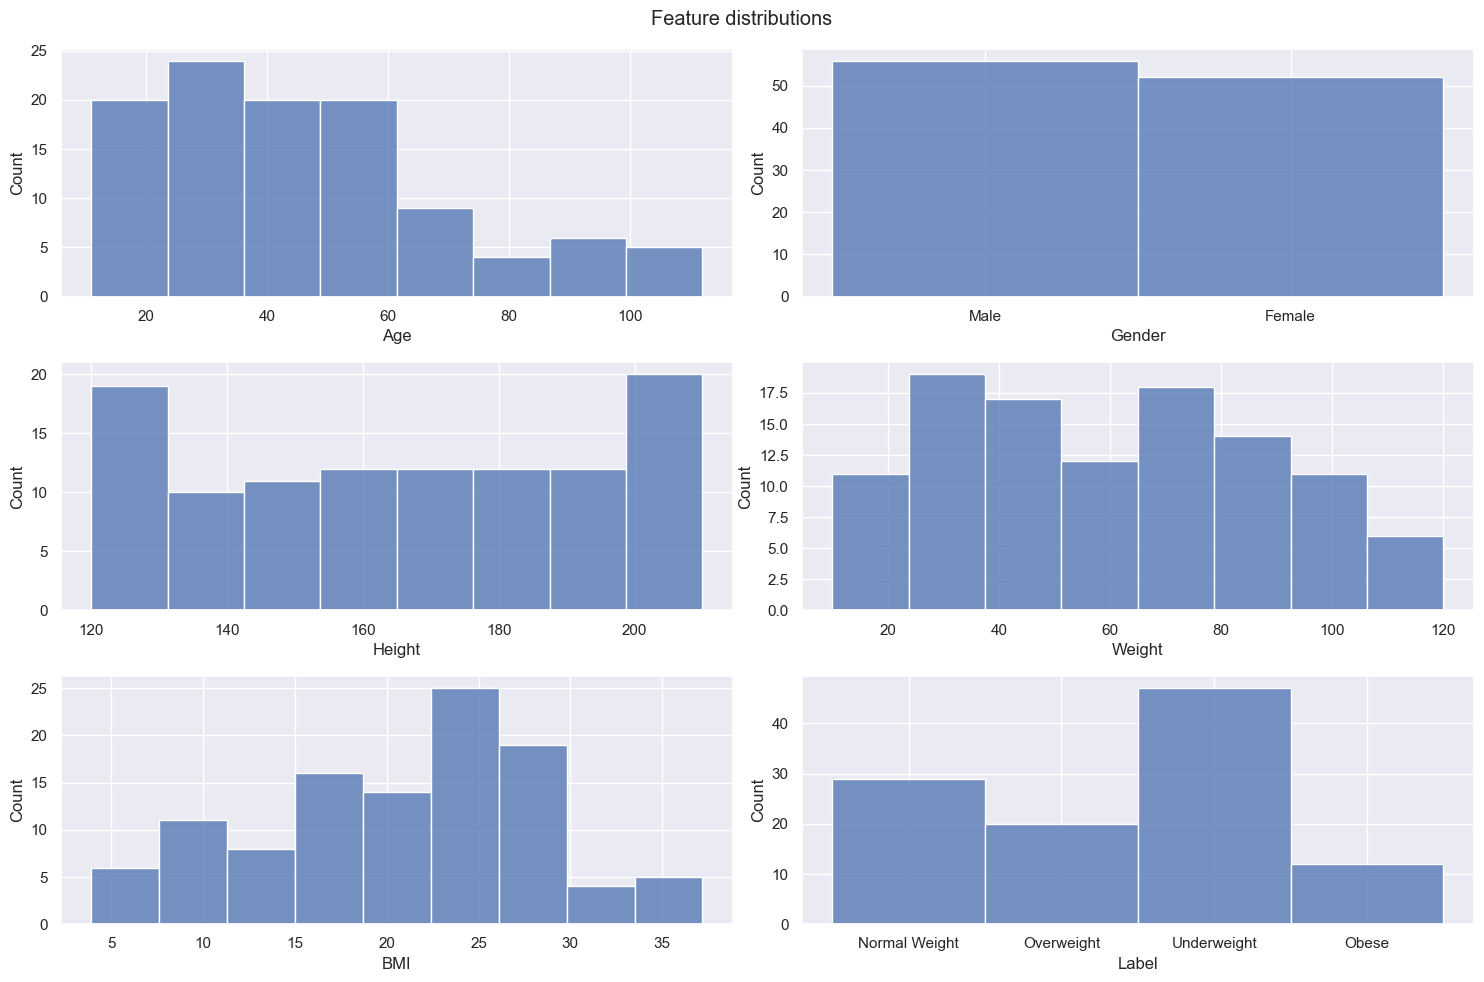

In [11]:
n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i in range(n_rows):
    for j in range(n_cols):
        feature = data.columns[i*n_cols+j]
        sns.histplot(x=data[feature], ax=axs[i][j])

fig.suptitle("Feature distributions")
fig.tight_layout()
fig.show()

There are no significant outliers.

# EDA

Now that the data is in the right format, let's have our first discussion with it. In this section, we'll analyse the feature distributions, inter-feature relationships, and the affects of certain features on obesity rates.

## Pairplot

Pairplots allow us to visualise the relationship between features of the dataset.

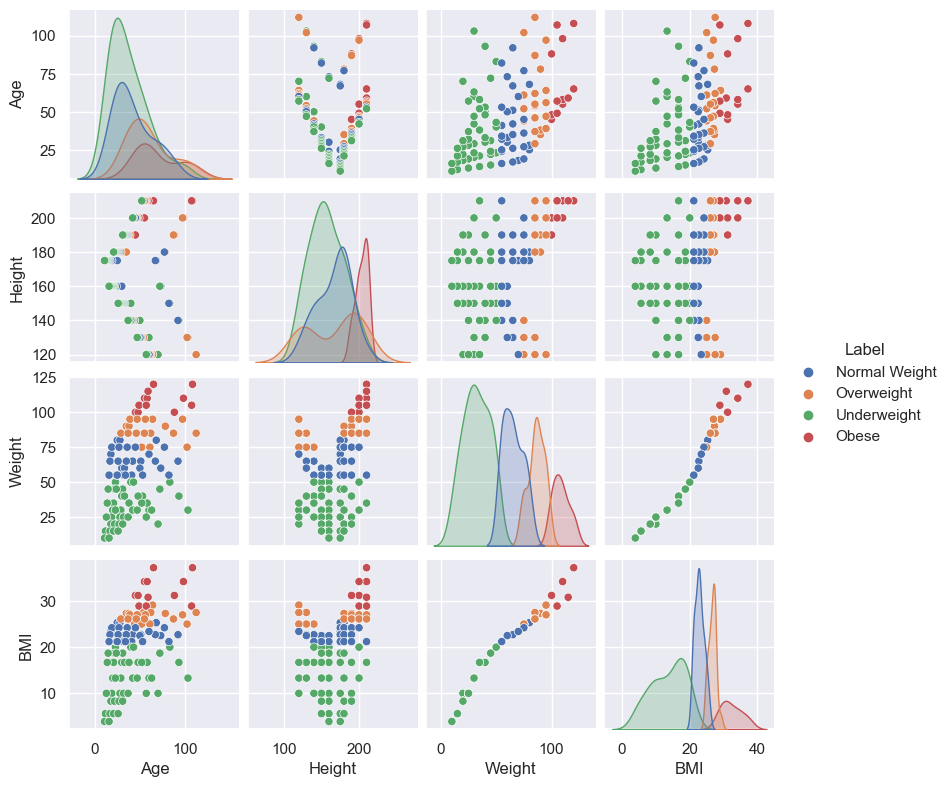

In [12]:
sns.pairplot(data, hue="Label", size=2)
plt.show()

## Effect of Gender on Obesity

Let's understand how gender affects obesity rates.

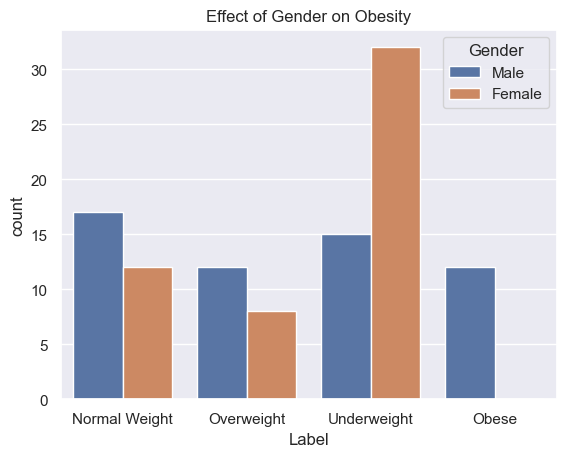

In [13]:
sns.countplot(data=data, x="Label", hue="Gender")
plt.title("Effect of Gender on Obesity")
plt.show()

From this chart we can observe that male individuals have a higher chance of being obese and overweight, while Female individuals have a higher chance of being Underweight.

## Understanding the data

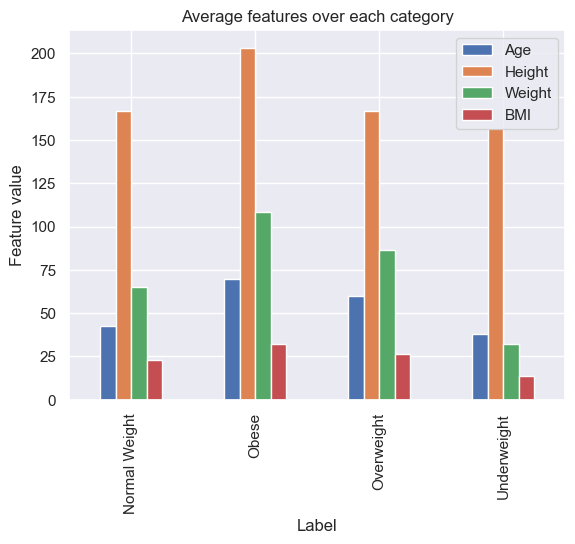

In [14]:
data.groupby("Label")[["Age", "Height", "Weight", "BMI"]].mean().plot(kind="bar")
plt.title("Average features over each category")
plt.ylabel("Feature value")
plt.show()

From this chart we can observe that each feature is, on average, higher for Obese individuals.

This chart shows that on average, older individuals tend to have a higher chance of being obese.

## Correlations

To visualise the correlations, we first need to encode our categorical features and target variable.

In [16]:
data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,Male,175,80,25.3,Normal Weight
1,30,Female,160,60,22.5,Normal Weight
2,35,Male,180,90,27.3,Overweight
3,40,Female,150,50,20.0,Underweight
4,45,Male,190,100,31.2,Obese


In [17]:
# convert Gender into binary variable
processed_data = data.copy()
processed_data["Gender"] = LabelEncoder().fit_transform(processed_data["Gender"])

# map Label to ordinal encoding
label_map = {
    "Underweight": 1,
    "Normal Weight": 2,
    "Overweight": 3,
    "Obese": 4,
}
processed_data = processed_data.replace({"Label": label_map})

processed_data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,1,175,80,25.3,2
1,30,0,160,60,22.5,2
2,35,1,180,90,27.3,3
3,40,0,150,50,20.0,1
4,45,1,190,100,31.2,4


Note how I encoded the target variable. I used an ordinal encoding to preserve the order between the target variable values. First is Underweight (1), then Normal Weight (2), then Overweight (3), and finally Obese (4). This will make the correlations between the features and the target more interpretable.

Now that we have encoded our data so that it is purely numeric, we can visualise the correlations between each variable.

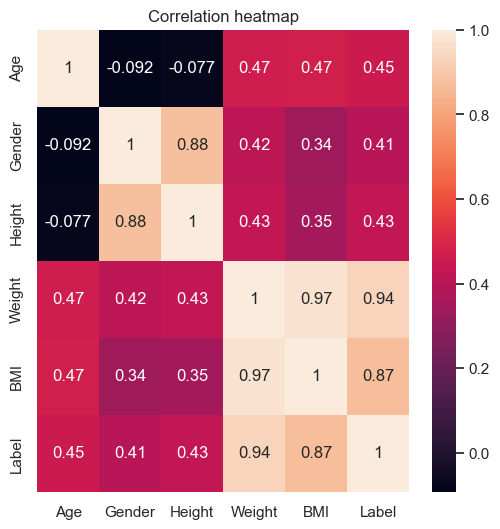

In [18]:
plt.figure(figsize=(6, 6))
sns.heatmap(processed_data.corr(), annot=True)
plt.title("Correlation heatmap")
plt.show()

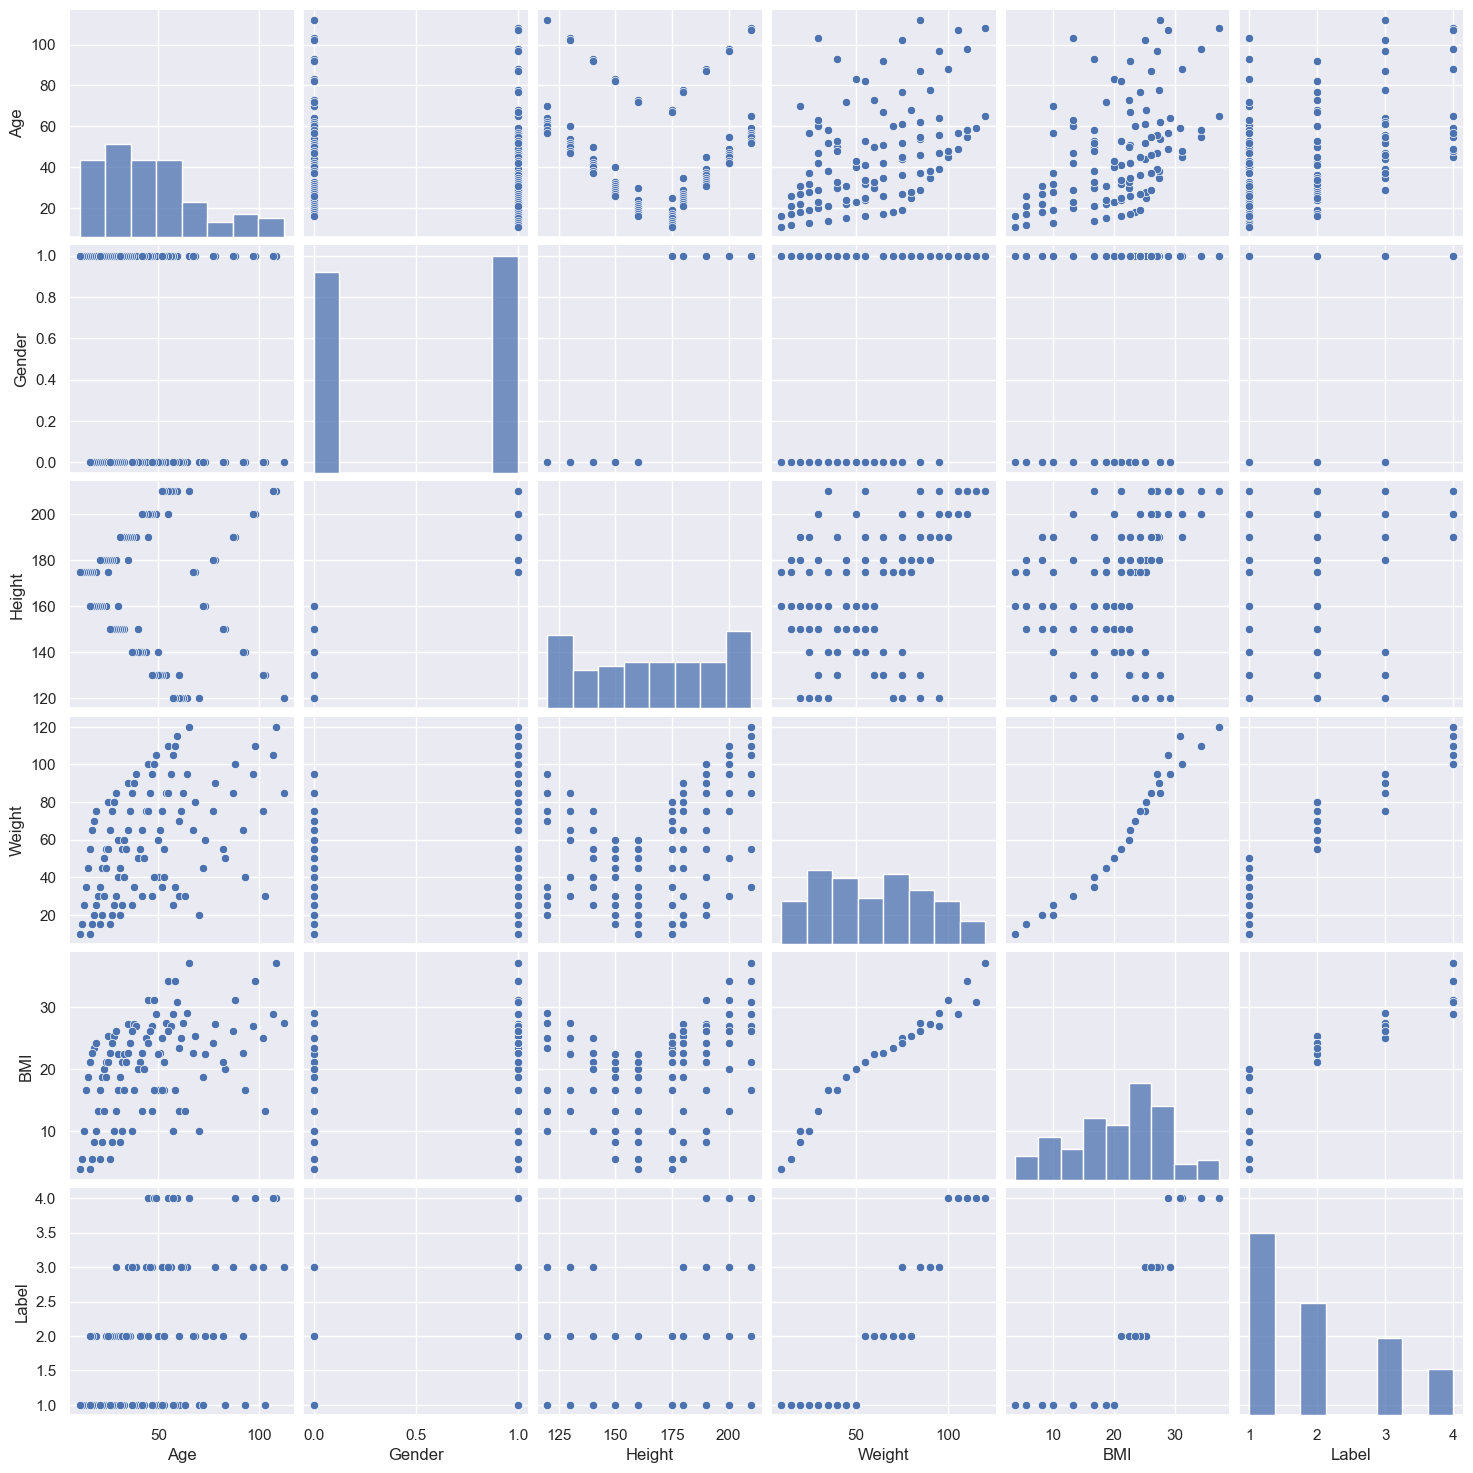

In [19]:
sns.pairplot(processed_data)
plt.show()

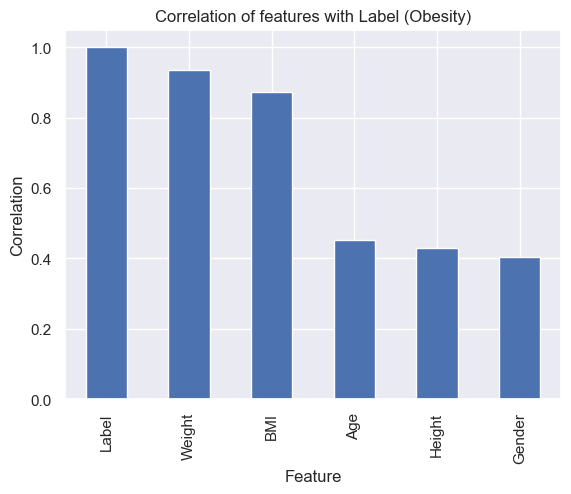

In [20]:
target_corr = processed_data.corr()["Label"]
target_corr = target_corr.sort_values(ascending=False)
target_corr.plot(kind="bar")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.title("Correlation of features with Label (Obesity)")
plt.show()

From these charts we can observe that Weight and BMI are strongly positively correlated with Obesity. This indicates that as Weight and BMI increase, the probability that the individual is Obese also increases.

# Feature engineering

Feature engineering involves transforming the existing features of the dataset into new features, to uncover hidden relationships in the data.

In [21]:
X = processed_data[["Weight", "BMI", "Age", "Height", "Gender"]]
y = processed_data["Label"]

print(X.shape)
print(y.shape)

(108, 5)
(108,)


## Polynomial features

Polynomial features are when we convert existing features into higher-order features.

In [22]:

poly = PolynomialFeatures(2)
poly.fit(X)
poly_feats = pd.DataFrame(data=poly.transform(X), columns=poly.get_feature_names_out())
poly_feats = poly_feats.iloc[:, 1:]
print(poly_feats.shape)
poly_feats.head()

(108, 20)


,Weight,BMI,Age,Height,Gender,Weight^2,Weight BMI,Weight Age,Weight Height,Weight Gender,BMI^2,BMI Age,BMI Height,BMI Gender,Age^2,Age Height,Age Gender,Height^2,Height Gender,Gender^2
0,80.0,25.3,25.0,175.0,1.0,6400.0,2024.0,2000.0,14000.0,80.0,640.09,632.5,4427.5,25.3,625.0,4375.0,25.0,30625.0,175.0,1.0
1,60.0,22.5,30.0,160.0,0.0,3600.0,1350.0,1800.0,9600.0,0.0,506.25,675.0,3600.0,0.0,900.0,4800.0,0.0,25600.0,0.0,0.0
2,90.0,27.3,35.0,180.0,1.0,8100.0,2457.0,3150.0,16200.0,90.0,745.29,955.5,4914.0,27.3,1225.0,6300.0,35.0,32400.0,180.0,1.0
3,50.0,20.0,40.0,150.0,0.0,2500.0,1000.0,2000.0,7500.0,0.0,400.00,800.0,3000.0,0.0,1600.0,6000.0,0.0,22500.0,0.0,0.0
4,100.0,31.2,45.0,190.0,1.0,10000.0,3120.0,4500.0,19000.0,100.0,973.44,1404.0,5928.0,31.2,2025.0,8550.0,45.0,36100.0,190.0,1.0


Above, we can see all the polynomial features that were generated. While some are based on a single feature (`Weight^2`), others are calculated through interactions between two features (`Weight BMI = Weight * BMI`).

In [23]:
poly_feats["Label"] = y

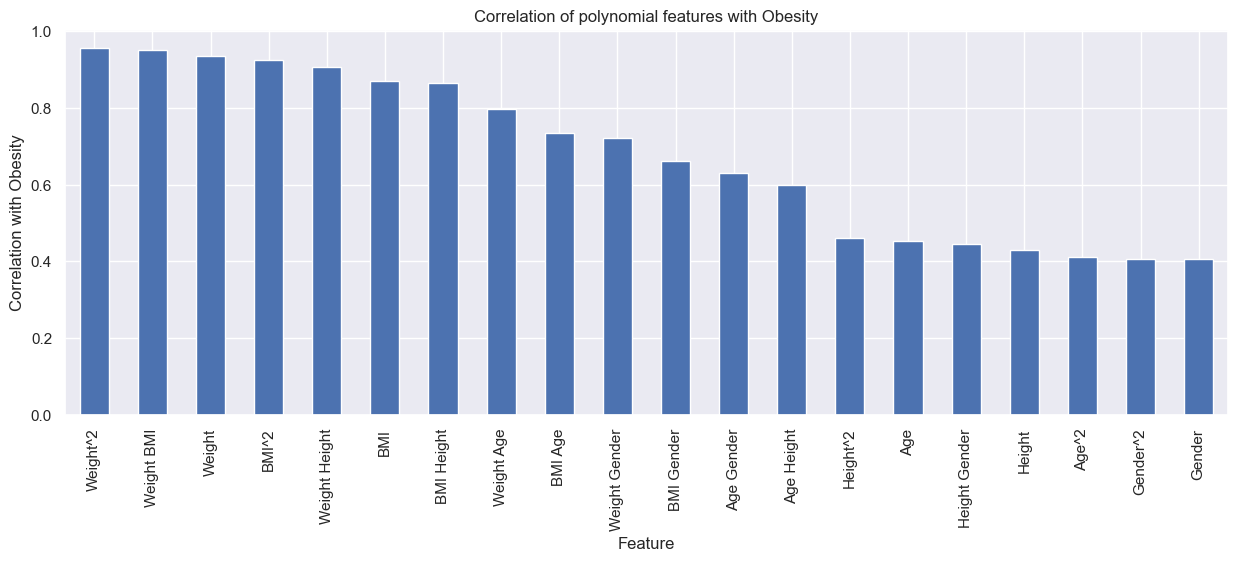

In [24]:
target_corr = poly_feats.corr()["Label"]
target_corr = target_corr.sort_values(ascending=False)

plt.figure(figsize=(15, 5))
target_corr[1:].plot(kind="bar")
plt.xlabel("Feature")
plt.ylabel("Correlation with Obesity")
plt.title("Correlation of polynomial features with Obesity")
plt.show()

Nice! Looks like incorporating polynomial features produces some new features with strong correlations to the target variable.

# Models

Now that we've explored the data, let's see if we can create a few models to predict whether a new patient has obesity, given their Age, Weight, Height, BMI, and Gender.

## Addressing the target distribution

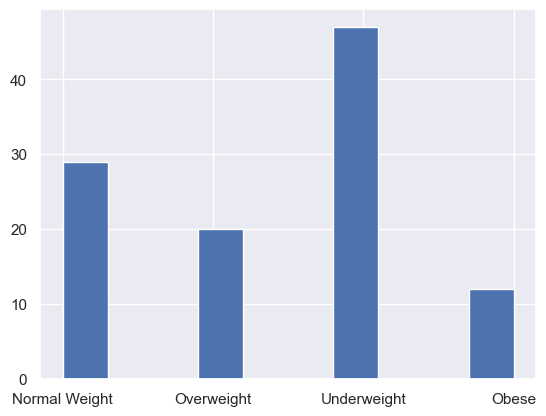

In [25]:
data["Label"].hist()
plt.show()

The target variable is serverly imbalanced, which may affect model performance (specifically recall) down the line.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Logistic Regression

In [27]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', LogisticRegressionCV(cv=5))
])

pipe.fit(X, y)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



## Decision Tree Classifier

In [32]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', DecisionTreeClassifier())
])

param_grid = {
    "estimator__criterion": ["gini", "entropy", "log_loss"],
    "estimator__splitter": ["best", "random"],
    "estimator__max_depth": [None, 4, 5],
}
search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('preprocessor', PolynomialFeatures()),
                                       ('estimator',
                                        DecisionTreeClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 4, 5],
                         'estimator__splitter': ['best', 'random']})

In [33]:
search.best_score_

0.9727272727272727

In [34]:
search.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__splitter': 'random'}

In [35]:
dt_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', DecisionTreeClassifier(criterion="log_loss", max_depth=5))
])

dt_pipe.fit(X_train, y_train)
y_pred = dt_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.75      1.00      0.86         3

    accuracy                           0.95        22
   macro avg       0.94      0.95      0.94        22
weighted avg       0.97      0.95      0.96        22



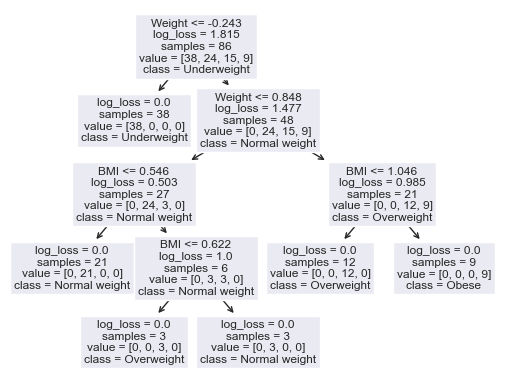

In [37]:
plot_tree(
    dt_pipe["estimator"],
    feature_names=list(X.columns),
    class_names=["Underweight", "Normal weight", "Overweight", "Obese"]
)
plt.show()

## Random Forest

In [38]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RandomForestClassifier())
])

param_grid = {
    "estimator__n_estimators": [50, 100, 150, 200],
    "estimator__criterion": ["gini", "entropy", "log_loss"],
    "estimator__max_depth": [None, 4, 5],
}
search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('preprocessor', PolynomialFeatures()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 4, 5],
                         'estimator__n_estimators': [50, 100, 150, 200]})

In [39]:
search.best_score_

0.9727272727272727

In [40]:
search.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__n_estimators': 50}

In [41]:
rf_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RandomForestClassifier(criterion="gini", n_estimators=50, max_depth=None))
])

rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

